Data in this notebook is sourced from the [MBTA Transit Reliability](https://mbta-massdot.opendata.arcgis.com/datasets/b3a24561c2104422a78b593e92b566d5_0/explore?filters=eyJtb2RlX3R5cGUiOlsiQ29tbXV0ZXIgUmFpbCJdLCJzZXJ2aWNlX2RhdGUiOlsxNzA0MTA3ODY0MjY1LjM1LDE3MTk3MjAwMDAwMDBdLCJtZXRyaWNfdHlwZSI6WyJIZWFkd2F5IC8gU2NoZWR1bGUgQWRoZXJlbmNlIl19) dataset.

In [1]:
%%capture
%pip install pandas

In [2]:
import pandas as pd

raw_data = pd.read_csv("cr_2024_q2_sched_adherance.csv")
raw_data

,service_date,gtfs_route_id,gtfs_route_short_name,gtfs_route_long_name,gtfs_route_desc,route_category,mode_type,peak_offpeak_ind,metric_type,otp_numerator,otp_denominator,cancelled_numerator,ObjectId
0,2024/06/29 04:00:00+00,CR-Kingston,NaN,Kingston/Plymouth Line,Commuter Rail,NaN,Commuter Rail,OFF_PEAK,Headway / Schedule Adherence,16,18,0,72
1,2024/06/29 04:00:00+00,CR-Lowell,NaN,Lowell Line,Commuter Rail,NaN,Commuter Rail,OFF_PEAK,Headway / Schedule Adherence,16,18,0,77
2,2024/06/28 04:00:00+00,CR-Newburyport,NaN,Newburyport/Rockport Line,Commuter Rail,NaN,Commuter Rail,OFF_PEAK,Headway / Schedule Adherence,22,24,0,97
3,2024/06/29 04:00:00+00,CR-Middleborough,NaN,Middleborough/Lakeville Line,Commuter Rail,NaN,Commuter Rail,OFF_PEAK,Headway / Schedule Adherence,17,20,0,124
4,2024/06/28 04:00:00+00,CR-Providence,NaN,Providence/Stoughton Line,Commuter Rail,NaN,Commuter Rail,OFF_PEAK,Headway / Schedule Adherence,20,25,0,161
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2424,2024/04/01 04:00:00+00,CR-Providence,NaN,Providence/Stoughton Line,Commuter Rail,NaN,Commuter Rail,PEAK,Headway / Schedule Adherence,9,9,0,21048
2425,2024/04/01 04:00:00+00,CR-Providence,NaN,Providence/Stoughton Line,Commuter Rail,NaN,Commuter Rail,PEAK,Headway / Schedule Adherence,12,12,0,21049
2426,2024/04/01 04:00:00+00,CR-Fairmount,NaN,Fairmount Line,Commuter Rail,NaN,Commuter Rail,PEAK,Headway / Schedule Adherence,9,10,0,21198
2427,2024/04/01 04:00:00+00,CR-Fitchburg,NaN,Fitchburg Line,Commuter Rail,NaN,Commuter Rail,PEAK,Headway / Schedule Adherence,11,11,0,21199


In [3]:
# Clean up columns that we won't use
cleaned_data = raw_data.drop(columns=[
  "gtfs_route_id",
  "gtfs_route_short_name",
  "gtfs_route_desc",
  "route_category",
  "mode_type",
  "peak_offpeak_ind",
  "metric_type",
  "cancelled_numerator",
  "ObjectId"
]).reindex()

# Clean up timestamps (we only care about the date, every time is the same)
cleaned_data.service_date = pd.to_datetime(raw_data["service_date"]).dt.date

# There are sometimes duplicate date entries... combine them by sum for now
cleaned_data = cleaned_data.groupby(["service_date", "gtfs_route_long_name"]).agg("sum")

cleaned_data

otp_numerator  otp_denominator
service_date gtfs_route_long_name                                        
2024-04-01   Fairmount Line                           37               40
             Fitchburg Line                           36               38
             Framingham/Worcester Line                54               54
             Franklin Line                            25               26
             Greenbush Line                           25               26
...                                                  ...              ...
2024-06-29   Kingston/Plymouth Line                   16               18
             Lowell Line                              16               18
             Middleborough/Lakeville Line             17               20
             Newburyport/Rockport Line                29               36
             Providence/Stoughton Line                17               20

[1075 rows x 2 columns]

In [4]:
# Calculate percentage based on numerator and denominator
def to_percent(row):
  if row.otp_denominator == 0:
    return 0
  
  return round(row.otp_numerator / row.otp_denominator, 4)

with_percent = cleaned_data
with_percent["on_time_percentage"] = cleaned_data.apply(to_percent, axis=1)
with_percent = with_percent.drop(columns=["otp_numerator", "otp_denominator"])

with_percent

on_time_percentage
service_date gtfs_route_long_name                            
2024-04-01   Fairmount Line                            0.9250
             Fitchburg Line                            0.9474
             Framingham/Worcester Line                 1.0000
             Franklin Line                             0.9615
             Greenbush Line                            0.9615
...                                                       ...
2024-06-29   Kingston/Plymouth Line                    0.8889
             Lowell Line                               0.8889
             Middleborough/Lakeville Line              0.8500
             Newburyport/Rockport Line                 0.8056
             Providence/Stoughton Line                 0.8500

[1075 rows x 1 columns]

## Per-Line Graphs

In [5]:
%%capture
%pip install matplotlib

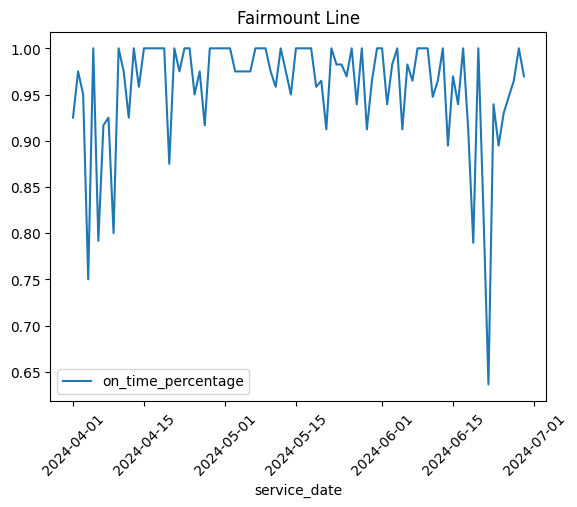

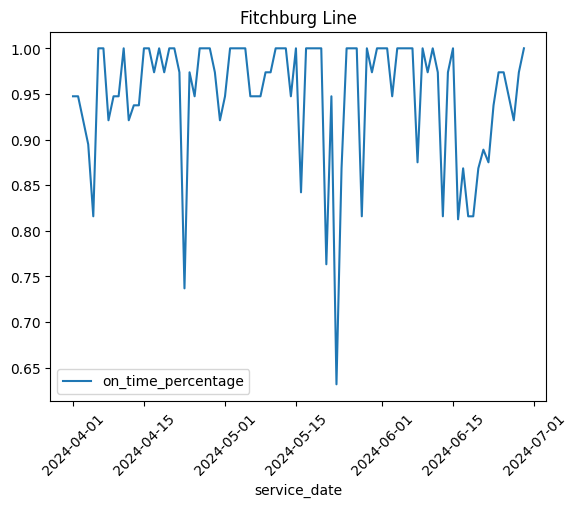

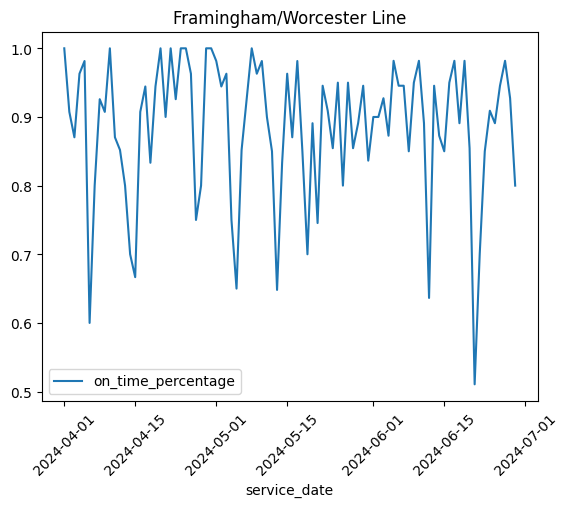

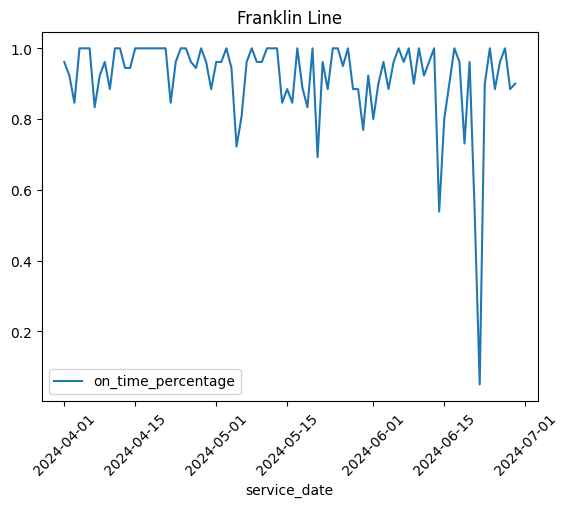

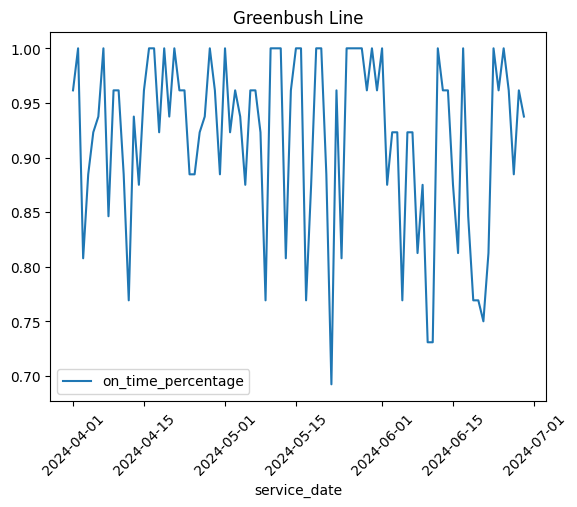

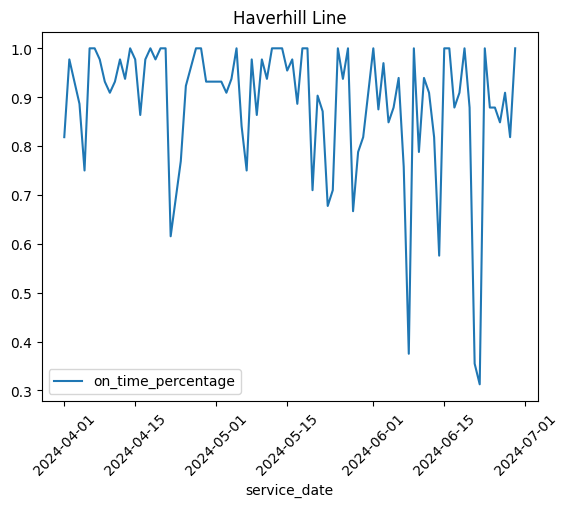

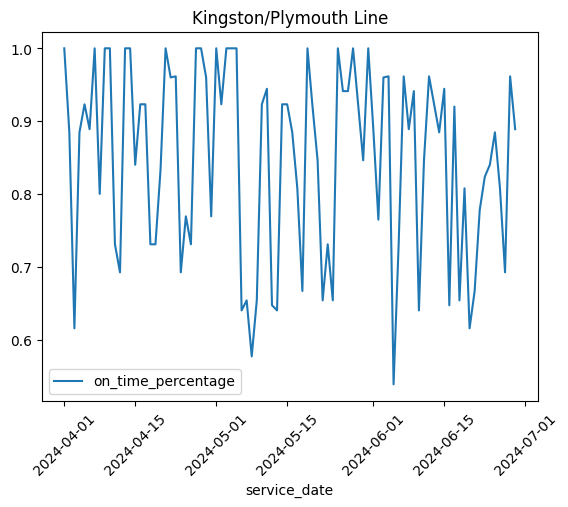

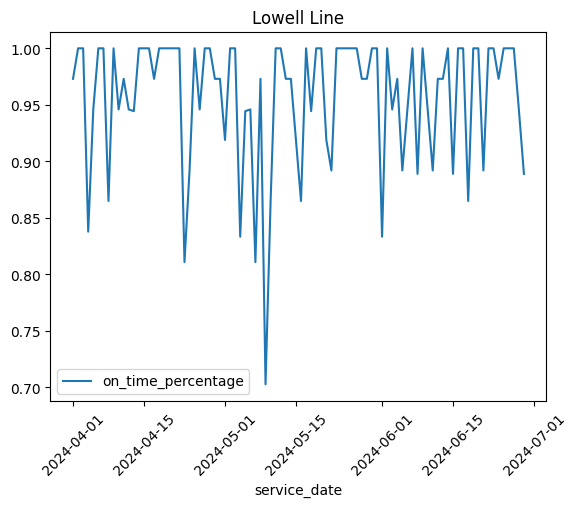

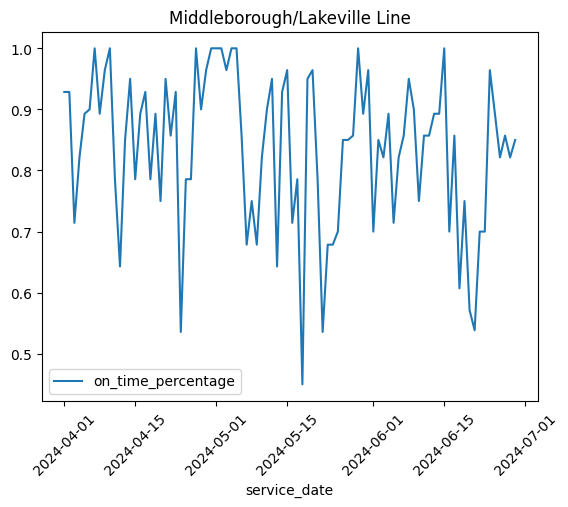

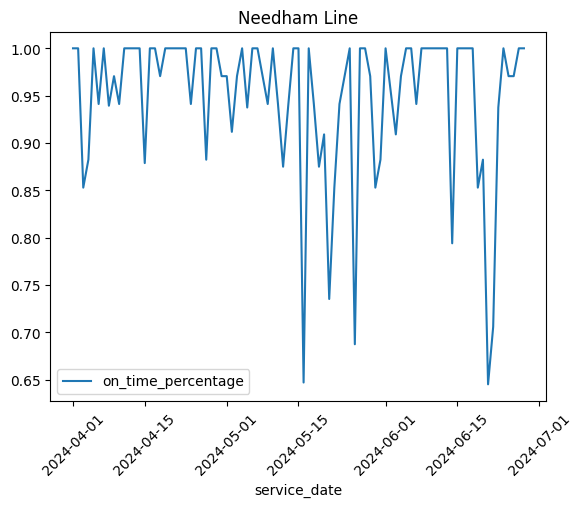

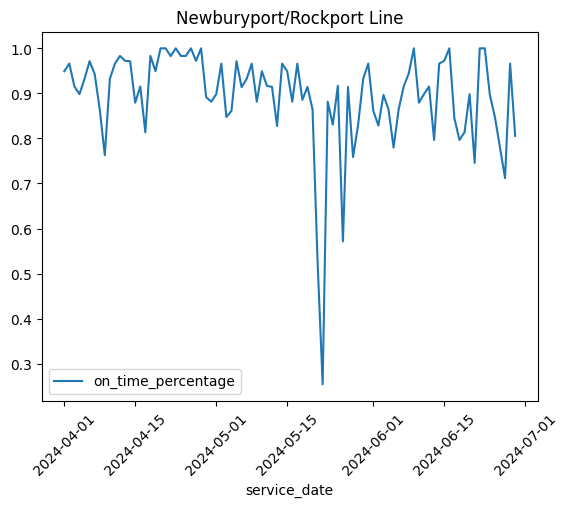

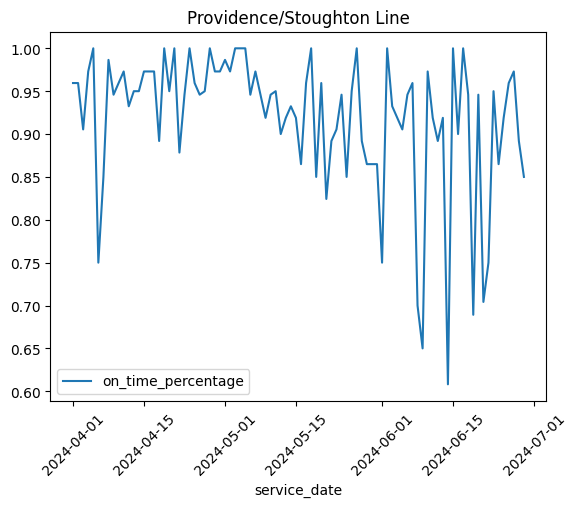

In [6]:
for line, details in with_percent.reset_index().groupby(["gtfs_route_long_name"]):
    details.drop(["gtfs_route_long_name"], axis=1, inplace=True)
    details.set_index("service_date", inplace=True)
    details.plot(title=line[0], rot=45)

## Blog Post Outputs

Now, to prepare the data for use with [Charts.js](https://www.chartjs.org/) to display on the blog. It needs to fit into (roughly)

```js
new Chart(ctx, {
  type: "line",
  data: {
    labels: dates, // From the notebook
    datasets: [
      {
        label: "CR Line Name",
        data: [], // datapoints
        borderWidth: 1
      },
      // ...
    ]
  }
});
```

First, we need the labels (AKA the dates) by themselves:

In [7]:
import json

In [8]:
date_labels = with_percent.index.get_level_values("service_date").unique()
date_labels = [str(date_label) for date_label in date_labels]
date_labels.sort()
print(json.dumps(date_labels, indent=2))

[
  "2024-04-01",
  "2024-04-02",
  "2024-04-03",
  "2024-04-04",
  "2024-04-05",
  "2024-04-06",
  "2024-04-07",
  "2024-04-08",
  "2024-04-09",
  "2024-04-10",
  "2024-04-11",
  "2024-04-12",
  "2024-04-13",
  "2024-04-14",
  "2024-04-15",
  "2024-04-16",
  "2024-04-17",
  "2024-04-18",
  "2024-04-19",
  "2024-04-20",
  "2024-04-21",
  "2024-04-22",
  "2024-04-23",
  "2024-04-24",
  "2024-04-25",
  "2024-04-26",
  "2024-04-27",
  "2024-04-28",
  "2024-04-29",
  "2024-04-30",
  "2024-05-01",
  "2024-05-02",
  "2024-05-03",
  "2024-05-04",
  "2024-05-05",
  "2024-05-06",
  "2024-05-07",
  "2024-05-08",
  "2024-05-09",
  "2024-05-10",
  "2024-05-11",
  "2024-05-12",
  "2024-05-13",
  "2024-05-14",
  "2024-05-15",
  "2024-05-16",
  "2024-05-17",
  "2024-05-18",
  "2024-05-19",
  "2024-05-20",
  "2024-05-21",
  "2024-05-22",
  "2024-05-23",
  "2024-05-24",
  "2024-05-25",
  "2024-05-26",
  "2024-05-27",
  "2024-05-28",
  "2024-05-29",
  "2024-05-30",
  "2024-05-31",
  "2024-06-01",
  "202

Now to group the datapoints by line, make sure they're sorted by date still, and output what that looks like:

In [9]:
line_to_data = {}

for line, details in with_percent.groupby("gtfs_route_long_name"):
  details.sort_values("service_date", inplace=True)
  result = {
    "label": line,
    "data": details["on_time_percentage"].tolist(),
  }
  line_to_data[line] = result

print(json.dumps(line_to_data, indent=2))

{
  "Fairmount Line": {
    "label": "Fairmount Line",
    "data": [
      0.925,
      0.975,
      0.95,
      0.75,
      1.0,
      0.7917,
      0.9167,
      0.925,
      0.8,
      1.0,
      0.975,
      0.925,
      1.0,
      0.9583,
      1.0,
      1.0,
      1.0,
      1.0,
      1.0,
      0.875,
      1.0,
      0.975,
      1.0,
      1.0,
      0.95,
      0.975,
      0.9167,
      1.0,
      1.0,
      1.0,
      1.0,
      1.0,
      0.975,
      0.975,
      1.0,
      1.0,
      1.0,
      0.975,
      0.9583,
      1.0,
      0.975,
      0.95,
      1.0,
      1.0,
      1.0,
      1.0,
      0.9583,
      0.9649,
      0.9123,
      1.0,
      0.9825,
      0.9825,
      0.9697,
      1.0,
      0.9394,
      1.0,
      0.9123,
      0.9649,
      1.0,
      1.0,
      0.9394,
      0.9825,
      1.0,
      0.9123,
      0.9825,
      0.9649,
      1.0,
      1.0,
      1.0,
      0.9474,
      0.9649,
      1.0,
      0.8947,
      0.9697,
      0.9394,
      